## Desafio PANVEL

O Grupo Panvel preza muito pelo atendimento ao cliente e quer fazer isto de forma cada vez mais personalizada. Pensando nisto, foi solicitado ao time de ciência de dados que desenvolva uma forma de sinalizar para os times de negócio os diferentes grupos de clientes que temos, com objetivo de personalizar cada vez mais o atendimento, as ofertas e as campanhas de marketing para cada um deles.

O desafio proposto consiste em avaliar a amostra de dados disponibilizados e distribuir os clientes em N clusters (O número fica a critério de quem está realizando a análise, cuidando para não ficar segmentado demais nem irrelevante em termos de diferenciação). Estão sendo entregues dados amostrais anonimizados de clientes, itens e um período de vendas. Também é fornecido um dicionário com uma breve explicação sobre cada coluna contida.

Algumas perguntas importantes que precisam ser respondidas:

1 – Acredita que as informações disponibilizadas sejam suficientes para conseguirmos alcançar algum nível de personalização com nossos clientes?

2 – Quais principais dificuldade que encontrou ao lidar com este problema e com os dados disponíveis?

3 – Quais outras informações você julgaria relevante para poder atingir um nível de personalização ainda mais interessante?

4 – Pensando em produto de dados, como você acredita que poderia ser uma arquitetura para sustentar este produto e disponibilizar os resultados para o negócio? Não é necessário desenvolver a arquitetura, apenas apresentar a ideia ou um desenho de como seria este produto em produção.

Pedimos que seja realizada uma apresentação com o estudo realizado, as variáveis consideradas relevantes e a solução proposta, como se estivesse entregando o projeto para o cliente final. Também deve ser apresentado um notebook com uma análise exploratória a respeito dos dados disponibilizados, mostrando o seu entendimento do cenário de negócio ao qual estes dados pertencem. Posteriormente, o desenvolvimento do algoritmo para a clusterização dos clientes e, por fim, a explicação dos modelos testados e do resultado obtido.

In [162]:
# Load required packages
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gdp
from shapely.geometry import Point

from datetime import datetime

import seaborn as sns

sns.set()

from matplotlib.ticker import PercentFormatter

# Merge all parquet files
import os

## Para mapas
from shapely.geometry import Polygon, LineString, Point

## PAra cluster
from pylab import plot, show
from numpy import vstack, array
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans

# Supressing warnings
import warnings

warnings.filterwarnings("ignore")

In [35]:
### Format settings:
pd.set_option("display.float_format", lambda x: "%.2f" % x)

## 1. Carregar os dados

In [36]:
df_clientes = pd.read_parquet("./dados/Clientes.parquet", engine="pyarrow")
df_itens = pd.read_parquet("./dados/Itens.parquet", engine="pyarrow")

In [111]:
### Agrupando dados de vendas em um único df

file_path = "./dados_vendas/"
file_list = os.listdir(file_path)

df = pd.DataFrame()
for file in file_list:
    fp = os.path.join(file_path, file)
    data = pd.read_parquet(fp)
    df = pd.concat([df, data], axis=0)

## Parte A: Visão geral dos dados

## 2.  Tabela Clientes

### Objetivo: Identificar o cliente médio

In [38]:
### Avaliar dados missing
percent_missing = df_clientes.isnull().sum() * 100 / len(df_clientes)
percent_missing

codigo_cliente        0.00
data_nascimento       0.67
idade                 0.67
faixa_etaria          0.67
faixa_etaria_ibge     0.67
sexo                  0.37
estado_civil         56.92
flag_optin_celular    0.00
flag_optin_fixo       0.00
flag_optin_email      0.00
uf                   30.97
cidade               30.97
bairro               30.97
status                0.00
dtype: float64

###  Filtros iniciais e formatação

In [39]:
## Excluir NaN para variaveis com razao de dados missing < 1%
df_clientes = df_clientes[df_clientes["data_nascimento"].notna()]

df_clientes = df_clientes[df_clientes["sexo"].notna()]
df_clientes = df_clientes[df_clientes["sexo"] != ""]

## Excluir variaveis que expressam a mesma coisa

### Fiz vários testes e percebi que algumas idades não condiziam com a faixa etaria, optei por recriar tal variável
df_clientes.drop(columns=["faixa_etaria", "faixa_etaria_ibge"], inplace=True)

## Definir faixa_etaria como category -> fazer ajuste em 100+ para melhor representação
# Create mileage buckets

faixa_etaria = [x for x in range(0, 99, 10)] + [np.inf]


def add_faixa_etaria(df, field):
    df["faixa_etaria"] = pd.cut(df[field], faixa_etaria)
    return df


df_clientes = add_faixa_etaria(df_clientes, "idade")

df_clientes["faixa_etaria"] = pd.Categorical(
    df_clientes["faixa_etaria"],
    ordered=True,
)

### Distribuição geográfica - clientes PanVel

In [40]:
### Identifcar clientes da região Sul

df_clientes["sul"] = np.where(
    (df_clientes["uf"].isin(["RS", "SC", "PR"])),
    1,
    0,
)

### Manter a informacao de uf = NaN como NaN
df_clientes["sul"].loc[~df_clientes["uf"].notna()] = np.nan

In [41]:
### Total tender types per quote

stats = df_clientes.groupby(["sul"], dropna=False, as_index=True, sort=True).agg(
    {
        "codigo_cliente": ["nunique"],
    }
)

stats.columns = stats.columns.droplevel(1)
stats.rename(columns={"codigo_cliente": "#_clientes"}, inplace=True)

stats["%_clientes"] = (stats["#_clientes"] / len(df_clientes)) * 100

stats.reset_index(inplace=True)

display(stats)

,sul,#_clientes,%_clientes
0,0.00,28098,1.51
1,1.00,1253781,67.58
2,NaN,573494,30.91


In [42]:
### Total tender types per quote

stats_state = df_clientes.groupby(["uf"], dropna=False, as_index=True, sort=True).agg(
    {
        "codigo_cliente": ["nunique"],
    }
)

stats_state.columns = stats_state.columns.droplevel(1)
stats_state.rename(columns={"codigo_cliente": "#_clientes"}, inplace=True)

stats_state["%_clientes"] = (stats_state["#_clientes"] / len(df_clientes)) * 100

stats_state.reset_index(inplace=True)

stats_state.sort_values(by="%_clientes", ascending=False).head(5)

,uf,#_clientes,%_clientes
24,RS,951274,51.27
30,NaN,573494,30.91
19,PR,168379,9.08
25,SC,134128,7.23
27,SP,21740,1.17


### Excluir UF = np.nan

In [43]:
df_clientes_uf = df_clientes[df_clientes["uf"].notna()]

In [44]:
### Total tender types per quote

stats_state = df_clientes_uf.groupby(
    ["uf"], dropna=False, as_index=True, sort=True
).agg(
    {
        "codigo_cliente": ["nunique"],
    }
)

stats_state.columns = stats_state.columns.droplevel(1)
stats_state.rename(columns={"codigo_cliente": "#_clientes"}, inplace=True)

stats_state["%_clientes"] = (stats_state["#_clientes"] / len(df_clientes_uf)) * 100

stats_state.reset_index(inplace=True)

stats_state.sort_values(by="%_clientes", ascending=False).head(5)

,uf,#_clientes,%_clientes
24,RS,951274,74.21
19,PR,168379,13.14
25,SC,134128,10.46
27,SP,21740,1.70
20,RJ,1394,0.11


Nota-se que o cliente mediano da Panbvel localiza-se na região SUl.

### Distribuição por genêro e faixa etária

In [45]:
### Avaliar por sexo e faixa etaria

stats = df_clientes.groupby(["sexo"], dropna=False, as_index=True, sort=True).agg(
    {
        "codigo_cliente": ["nunique"],
        "idade": ["mean"],
    }
)

stats.columns = stats.columns.droplevel(1)
stats.rename(
    columns={"codigo_cliente": "#_clientes", "idade": "avg_idade"}, inplace=True
)

stats["share"] = 100 * stats["#_clientes"] / len(df_clientes)

stats = stats[["#_clientes", "share", "avg_idade"]]
display(stats)

##########################################################################

stats_sexo = df_clientes.groupby(
    ["sexo", "faixa_etaria"], dropna=False, as_index=True, sort=True
).agg(
    {
        "codigo_cliente": ["nunique"],
    }
)


stats_sexo.columns = stats_sexo.columns.droplevel(1)


stats_sexo.rename(columns={"codigo_cliente": "#_clientes"}, inplace=True)


# stats_sexo.reset_index(inplace=True)


# stats_sexo.set_index("sexo", inplace=True)


result = (df_clientes.groupby(["sexo"])["codigo_cliente"].nunique()).to_frame()


stats_sexo.head(50)


stats_sexo = stats_sexo.join(result)


stats_sexo["share_etaria_sexo"] = (
    100 * stats_sexo["#_clientes"] / stats_sexo["codigo_cliente"]
)


stats_sexo["share_total"] = 100 * stats_sexo["#_clientes"] / len(df_clientes)


stats_sexo.drop(columns=["codigo_cliente"])

,#_clientes,share,avg_idade
sexo,,,
F,1181508,63.68,44.87
M,673865,36.32,46.71


#_clientes  share_etaria_sexo  share_total
sexo faixa_etaria                                            
F    (0.0, 10.0]         2020               0.17         0.11
     (10.0, 20.0]       23946               2.03         1.29
     (20.0, 30.0]      214161              18.13        11.54
     (30.0, 40.0]      298716              25.28        16.10
     (40.0, 50.0]      240617              20.37        12.97
     (50.0, 60.0]      177485              15.02         9.57
     (60.0, 70.0]      136640              11.56         7.36
     (70.0, 80.0]       67285               5.69         3.63
     (80.0, 90.0]       18437               1.56         0.99
     (90.0, inf]         2200               0.19         0.12
M    (0.0, 10.0]         2026               0.30         0.11
     (10.0, 20.0]       10071               1.49         0.54
     (20.0, 30.0]      101988              15.13         5.50
     (30.0, 40.0]      161865              24.02         8.72
     (40.0, 50.0]      138382              20.54         7.46
     (50.0, 60.0]      106968              15.87         5.77
     (60.0, 70.0]       90383              13.41         4.87
     (70.0, 80.0]       48300               7.17         2.60
     (80.0, 90.0]       12778               1.90         0.69
     (90.0, inf]         1104               0.16         0.06

Text(0.5, 1.0, 'Fraçáo do total de clientes por faixa etária')

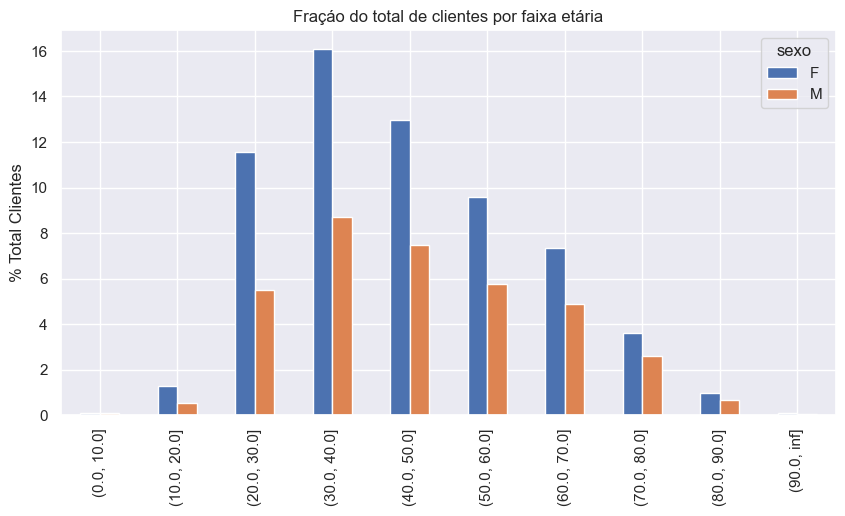

In [46]:
# Distribuição por faixa etária - Gráfico de barras

stats_sexo.reset_index(inplace=True)

df_bar = pd.pivot_table(
    stats_sexo,
    index="faixa_etaria",
    columns="sexo",
    values="share_total",
)

df_bar.plot(kind="bar", figsize=(10, 5))
plt.ylabel("% Total Clientes")
plt.ylim = (0, 10, 0.5)
plt.xlabel("")
plt.title("Fraçáo do total de clientes por faixa etária")

### Conclusòes preliminares:

* Cliente mediano:
  *  Mora na região Sul, é mulher, morador de centros urbanos de alta população e faixa etária entre 20 e 44 anos. 

* Para uma melhor categorização de clientes, irei filtrar:
  *  Estados do Sul;
  *  Menores de 10 anos 

In [47]:
## Filtros finais
df_clientes = df_clientes[df_clientes["sul"] == 1]

## Filtrar idades de pouca representatividade

df_clientes = df_clientes[(df_clientes["idade"] > 10) & (df_clientes["idade"] <= 90)]

In [48]:
print("\nTotal de clientes - Aplicados filtros:", len(df_clientes))


Total de clientes - Aplicados filtros: 1250402


## Dado externos -IBGE

### Para uma melhor vizualização podemos representar por meio de mapas. Para isso é necessário a geolocalização das cidades da região Sul.

### Dados População por cidade

In [49]:
### Populacao

### PEgar dados da populacao

# Get data
df_pop = pd.read_csv("./dados_ibge/populacao_sul_2020.csv")
df_pop = df_pop.rename({"Cidade Gaúcha": "cidade"}, axis=1)
df_pop["cidade"] = df_pop["cidade"].str.upper()
df_pop

# # criar a Boolean mask
mask = df_pop["cidade"] == "FLORIANÓPOLIS"
# # substituir valores
df_pop.loc[mask, "cidade"] = "FLORIANOPOLIS"

### Geolocalização para mapas (cidades)

In [50]:
uf_df = gdp.read_file("./dados_ibge/BR_UF_2020.shp")

In [51]:
### Trazer informação enterna (IBGE) para plotar mapas

cities = gdp.read_file("./dados_ibge/BR_Municipios_2020.shp")

cities = cities.rename({"NM_MUN": "cidade"}, axis=1)


### Para poder fazer o matching entre IBGE geopandas e a base Panvel:
cities["cidade"] = cities["cidade"].str.upper()

# # ## Aqui vale uma observação para atividades futuras (para mapas) - verirficar acentuação

# criar a Boolean mask
mask = cities["cidade"] == "FLORIANÓPOLIS"
# substituir valores
cities.loc[mask, "cidade"] = "FLORIANOPOLIS"

cities

,CD_MUN,cidade,SIGLA_UF,AREA_KM2,geometry
0,1100015,ALTA FLORESTA D'OESTE,RO,7067.13,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8..."
1,1100023,ARIQUEMES,RO,4426.57,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736..."
2,1100031,CABIXI,RO,1314.35,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3..."
3,1100049,CACOAL,RO,3793.00,"POLYGON ((-61.00080 -11.29737, -61.00103 -11.3..."
4,1100056,CEREJEIRAS,RO,2783.30,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0..."
...,...,...,...,...,...
5565,5222005,VIANÓPOLIS,GO,954.28,"POLYGON ((-48.38114 -16.63141, -48.38058 -16.6..."
5566,5222054,VICENTINÓPOLIS,GO,737.25,"POLYGON ((-49.84456 -17.58262, -49.84357 -17.5..."
5567,5222203,VILA BOA,GO,1060.17,"POLYGON ((-47.11416 -14.67412, -47.11289 -14.6..."
5568,5222302,VILA PROPÍCIO,GO,2181.58,"POLYGON ((-48.75586 -14.86267, -48.75519 -14.8..."


In [52]:
cities_south_region = cities.loc[
    cities.SIGLA_UF.isin(uf_df.loc[uf_df.NM_REGIAO == "Sul", "SIGLA_UF"])
]
cities_south_region["geometry"] = cities_south_region["geometry"].centroid

## Índice grau de inserção 

In [54]:
### Total tender types per quote

stats_city = df_clientes.groupby(
    ["cidade"], dropna=False, as_index=True, sort=True
).agg(
    {
        "codigo_cliente": ["nunique"],
    }
)

stats_city.columns = stats_city.columns.droplevel(1)
stats_city.rename(columns={"codigo_cliente": "#_clientes"}, inplace=True)

# stats_city["%_clientes"] = (stats_city["#_clientes"] / len(df_clientes)) * 100

stats_city = stats_city[stats_city["#_clientes"] >= 2000]
stats_city = stats_city.sort_values(by="#_clientes", ascending=False)
stats_city.reset_index(inplace=True)


## Combinar dados

df3 = pd.merge(cities_south_region, stats_city, how="left")

df3 = df3[df3["#_clientes"].notna()]
df3 = df3.drop(columns=["CD_MUN", "AREA_KM2"])

## Trazer dados de populacao
df4 = pd.merge(df3, df_pop, how="left")
df4["grau_insercao"] = df4["#_clientes"] / df4["pop"]
df4 = df4.drop(columns=["UF"])
df4_top10 = df4.sort_values(by="grau_insercao", ascending=False).head(10)

df4_top10.drop(columns={"SIGLA_UF", "geometry"})

,cidade,#_clientes,pop,grau_insercao
36,PORTO ALEGRE,373284.00,1488252,0.25
9,GAROPABA,5553.00,23579,0.24
30,GRAMADO,7012.00,36555,0.19
46,TORRES,6669.00,39064,0.17
37,RIO GRANDE,34718.00,211965,0.16
35,PELOTAS,50030.00,343132,0.15
44,TAPES,2349.00,17332,0.14
8,FLORIANOPOLIS,61139.00,508826,0.12
18,CANELA,5321.00,45488,0.12
13,ALEGRETE,8058.00,73028,0.11


### Aqui poode-se trazer mais dados externos, como pib e indicadoes do SUS para melhor entender socio-economicamente a adesão de pessos 

In [55]:
# Get state Map
state_UF = gdp.read_file("./dados_ibge/BR_UF_2020.shp")

state_SUL = state_UF.loc[state_UF["SIGLA_UF"].isin(["RS", "SC", "PR"])]

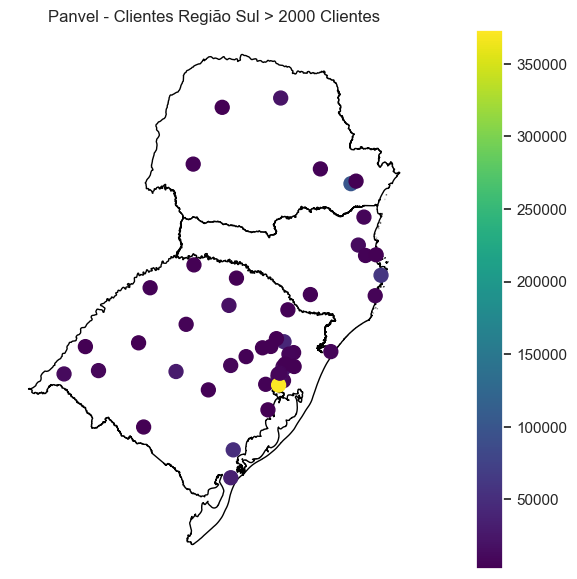

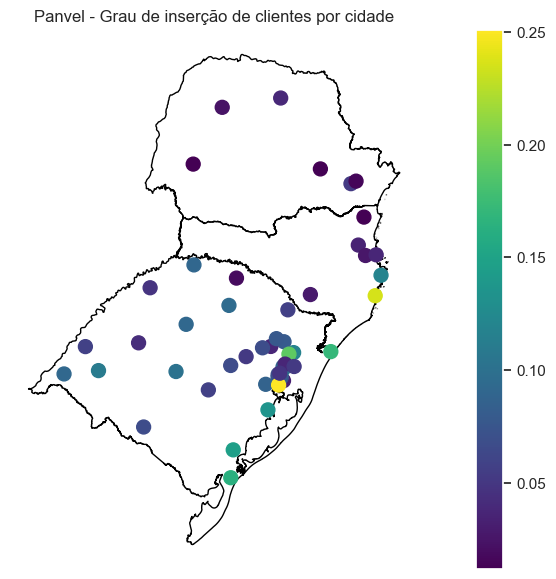

In [57]:
# Restrict to United States
fig, ax = plt.subplots(figsize=(15, 7))
state_SUL.plot(ax=ax, color="white", edgecolor="black")


df3.plot(ax=ax, column=("#_clientes"), legend=True, markersize=100)

# ax.figure.axes[0].yaxis.label.set_size(10)
# ax.set_title('Average Dryvan Distance per KMA_OB')


ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

plt.set_cmap("viridis")
plt.axis("off")

plt.set_cmap("viridis")
plt.title("Panvel - Clientes Região Sul > 2000 Clientes")
plt.show()

# Restrict to United States
fig, ax = plt.subplots(figsize=(15, 7))
state_SUL.plot(ax=ax, color="white", edgecolor="black")


df4.plot(ax=ax, column=("grau_insercao"), legend=True, markersize=100)

# ax.figure.axes[0].yaxis.label.set_size(10)
# ax.set_title('Average Dryvan Distance per KMA_OB')


ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

plt.set_cmap("viridis")
plt.axis("off")

plt.set_cmap("viridis")
plt.title("Panvel - Grau de inserção de clientes por cidade")
plt.show()

## 3. Entendendo os itens

In [58]:
### Avaliar dados missing
percent_missing = df_itens.isnull().sum() * 100 / len(df_itens)
percent_missing

cod_item             0.00
desc_tipo_item       0.00
desc_grupo           0.00
desc_subgrupo        0.00
desc_categoria       0.00
desc_subcategoria    0.00
flag_marca_propria   0.00
flag_otc             0.00
flag_uso_continuo    0.00
dtype: float64

In [59]:
print("\nTotal de items:", len(df_itens))


Total de items: 86618


In [60]:
print(
    f"Visão geral dos items comercializados: \n"
    f" - {df_itens.shape[0]} items \n"
    f" - {df_itens.desc_tipo_item.nunique()} Tipos de item \n"
    f" - {(df_itens[df_itens['flag_marca_propria'] == 'S'].cod_item.nunique())} Itens Marca Própria \n"
    f" - {(round((df_itens[df_itens['flag_uso_continuo'] == 'S'].cod_item.nunique())/len(df_itens)*100,2))}% Itens Uso Contínuo  \n"
)

Visão geral dos items comercializados: 
 - 86618 items 
 - 2 Tipos de item 
 - 7 Itens Marca Própria 
 - 8.68% Itens Uso Contínuo  



In [61]:
df_itens.desc_tipo_item.value_counts()

HB             61425
MEDICAMENTO    25193
Name: desc_tipo_item, dtype: int64

In [62]:
df_itens.desc_categoria.value_counts()

NAO DEFINIDO            20611
LABIOS                   4045
ESMALTAÇÃO               2956
SHAMPOO                  2341
FACE                     2314
                        ...  
LENCO HIGIENICO             1
LENÇOS UMEDECIDOS           1
KIT CUIDADO CORPORAL        1
TRATAMENTO CAPILAR          1
NORMAL                      1
Name: desc_categoria, Length: 559, dtype: int64

In [63]:
### Total tender types per quote

stats_items = df_itens.groupby(
    ["desc_tipo_item"], dropna=False, as_index=True, sort=True
).agg(
    {
        "cod_item": ["nunique"],
        "desc_grupo": ["nunique"],
        "desc_categoria": ["nunique"],
    }
)

stats_items.columns = stats_items.columns.droplevel(1)
stats_items.rename(
    columns={
        "cod_item": "#_items",
        "desc_grupo": "#_grupos",
        "desc_categoria": "#_categorias",
    },
    inplace=True,
)

stats_items["%_items"] = (stats_items["#_items"] / len(df_itens)) * 100

stats_items = stats_items[
    [
        "#_items",
        "%_items",
        "#_grupos",
        "#_categorias",
    ]
]

stats_items

,#_items,%_items,#_grupos,#_categorias
desc_tipo_item,,,,
HB,61425,70.91,49,477
MEDICAMENTO,25193,29.09,59,89


## 4. Entendendo as vendas

### Dados se referem ao periodo de 2022-06-01 ä 2022-06-15

In [113]:
### Avaliar dados missing

print("\nTotal de vendas:", len(df))
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing


Total de vendas: 39862994


cod_cliente      0.00
data_emissao     0.00
cod_item         0.00
quantidade       0.00
valor_bruto      0.00
valor_desconto   0.03
valor_liquido    0.00
dtype: float64

In [114]:
## Formatar e criar variaveis para análise

### Variáveis temporais

df["data_emissao"] = pd.to_datetime(df["data_emissao"])
df["dia"] = df.data_emissao.dt.day
df["dia_da_semana"] = df["data_emissao"].dt.dayofweek

df["dia_da_semana"] = df["dia_da_semana"].map(
    {0: "Seg", 1: "Ter", 2: "Qua", 3: "Qui", 4: "Sex", 5: "Sab", 6: "Dom"}
)

#### Definir variaveis como numericas

df["quantidade"] = pd.to_numeric(df["quantidade"])
df["valor_desconto"] = pd.to_numeric(df["valor_desconto"])
df["valor_bruto"] = pd.to_numeric(df["valor_bruto"])
df["valor_liquido"] = pd.to_numeric(df["valor_liquido"])

### valor_desconto: substituir NaN por 0
df["valor_desconto"] = df["valor_desconto"].fillna(0)

### Renomear variaveis

df.rename(
    columns={
        "valor_bruto": "valor_bruto_unitario",
        "valor_desconto": "valor_desc_unitario",
        "valor_liquido": "valor_liquido_total",
    },
    inplace=True,
)

#### Avaliar se produto esta em promoção ou outro caso especial

In [115]:
### Variaveis financeiras

df["valor_desconto_pct"] = (
    df["valor_desc_unitario"] / df["valor_bruto_unitario"]
) * 100

## identificar se em regime especial de preço (PROMOÇÃO)
df["valor_liquido_unitario"] = df["valor_bruto_unitario"] - df["valor_desc_unitario"]

### Fazer teste de valor unitario
df["valor_liquido_unitario_DEBUG"] = df["valor_liquido_total"] / df["quantidade"]

In [116]:
### Por algum motivo, o valor liquido nào faz sentido em alguns casos (Seria alguma Promocao ou caso especial?) Deixei uma tolerancia de R$0.05

df["Equal"] = np.isclose(
    df["valor_liquido_unitario"], df["valor_liquido_unitario_DEBUG"], atol=0.05
)

df["Equal"] = df["Equal"].astype(int)

### Como desconheço a regra de negocio para esses casos, optei por filtrar esses dados
print("\nTotal de transacoes PROMO:", len(df[df["Equal"] == 0]))
print(
    "\nTotal de transacoes PROMO %:",
    round(len(df[df["Equal"] == 0]) / len(df) * 100, 2),
)


Total de transacoes PROMO: 6104789

Total de transacoes PROMO %: 15.31


In [118]:
# ### Reordenar colunas

df = df[
    [
        "cod_cliente",
        "data_emissao",
        "dia",
        "dia_da_semana",
        "cod_item",
        "quantidade",
        "valor_bruto_unitario",
        "valor_desc_unitario",
        "valor_desconto_pct",
        "valor_liquido_total",
        "valor_liquido_unitario",
        "valor_liquido_unitario_DEBUG",
        "Equal",
    ]
]

df

,cod_cliente,data_emissao,dia,dia_da_semana,cod_item,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_desconto_pct,valor_liquido_total,valor_liquido_unitario,valor_liquido_unitario_DEBUG,Equal
0,2211,2022-06-01,1,Qua,357537,1,83.06,11.63,14.00,71.43,71.43,71.43,1
1,2211,2022-06-01,1,Qua,647860,1,149.49,0.00,0.00,149.49,149.49,149.49,1
2,4553,2022-06-01,1,Qua,116065,1,94.90,0.00,0.00,94.90,94.90,94.90,1
3,4553,2022-06-01,1,Qua,853800,2,24.99,15.00,60.02,19.98,9.99,9.99,1
4,4553,2022-06-01,1,Qua,880550,1,71.99,0.00,0.00,71.99,71.99,71.99,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036851,142582667,2022-06-15,15,Qua,304940,1,10.49,2.10,20.02,8.39,8.39,8.39,1
2036852,142582667,2022-06-15,15,Qua,379701,1,34.26,18.87,55.08,15.39,15.39,15.39,1
2036853,142582667,2022-06-15,15,Qua,431370,1,26.14,6.54,25.02,19.60,19.60,19.60,1
2036854,142582667,2022-06-15,15,Qua,826940,1,15.00,4.50,30.00,10.50,10.50,10.50,1


In [121]:
### Com esse filtro, penso filtrar os produtos que estavam em algum regime especial de vendas
df1 = df[df["Equal"] == 1]

## 5. Remover outliers

A presença de outliers pode enviesar a cliusterização

Vários procedimentos foram feitos, (z-normal ou 3 stdv) porém não retornaram resultados satisfatórios. 

In [122]:
df1.describe()

,cod_cliente,dia,cod_item,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_desconto_pct,valor_liquido_total,valor_liquido_unitario,valor_liquido_unitario_DEBUG,Equal
count,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00,33758205.00
mean,29150792.21,8.09,337004.83,1.06,27.76,7.11,23.19,22.45,20.64,20.64,1.00
std,50579290.78,4.48,302872.33,0.43,72.57,18.46,16.44,91.45,58.32,58.32,0.00
min,2138.00,1.00,27.00,1.00,0.01,0.00,0.00,0.00,0.00,0.00,1.00
25%,3030882.00,3.00,109381.00,1.00,8.49,0.90,15.01,6.86,6.76,6.76,1.00
50%,4681677.00,9.00,117129.00,1.00,19.27,3.40,20.02,13.59,13.33,13.33,1.00
75%,9547457.00,12.00,556730.00,1.00,29.99,8.21,28.14,24.59,23.99,23.99,1.00
max,142582667.00,15.00,999230.00,200.00,63506.90,14378.42,100.00,250247.31,55886.07,55886.07,1.00


Atenção aos valores de valor_unitario_bruto e vaslor_desc_unitario que indicam a presença de outliers. A presença de outliers pode enviesar a cliusterização

Vários procedimentos foram feitos, (z-normal ou 3 stdv) porém não retornaram resultados satisfatórios. 

In [123]:
### Filtros
df2 = df1[(df1["valor_desc_unitario"] <= 30) & (df1["valor_bruto_unitario"] <= 150)]

In [124]:
print(
    "\nProporção de dados removidos %:",
    round((len(df1) - len(df2)) / len(df1) * 100, 2),
)


Proporção de dados removidos %: 3.7


### Identificar a dinâmica temporal de compras

In [125]:
### Identificar receita e quantidade diária

stats_vendas = df2.groupby(
    ["data_emissao"], dropna=False, as_index=True, sort=True
).agg(
    {
        "cod_cliente": ["count", "nunique"],
        "cod_item": ["nunique"],
        "quantidade": ["sum", "mean"],
        "valor_desc_unitario": ["sum"],
        "valor_desconto_pct": ["mean"],
        "valor_liquido_unitario": ["mean"],
        "valor_liquido_total": ["mean", "sum"],
    }
)

stats_vendas.columns = stats_vendas.columns.droplevel(1)


### Como tenho duas colunas com memso nome, preciso renomear as colunas
stats_vendas.columns = [
    "#_transacoes",
    "#_clientes",
    "#_itens",
    "quantidade_TOTAL",
    "quantidade_media",
    "valor_desc_unitario_TOTAL",
    "valor_desc_pct_media",
    "valor_liquido_unitario_media",
    "valor_liquido_total_media",
    "valor_liquido_totasl_TOTAL",
]


stats_vendas

,#_transacoes,#_clientes,#_itens,quantidade_TOTAL,quantidade_media,valor_desc_unitario_TOTAL,valor_desc_pct_media,valor_liquido_unitario_media,valor_liquido_total_media,valor_liquido_totasl_TOTAL
data_emissao,,,,,,,,,,
2022-06-01,2162411,296451,12419,2382895,1.10,11663007.93,17.83,30.99,37.82,81783180.97
2022-06-02,848461,297779,12415,880116,1.04,5272178.06,27.19,17.35,17.84,15137308.88
2022-06-03,5184668,303497,12534,5215818,1.01,24729925.33,23.27,15.54,15.61,80955733.55
2022-06-04,1788454,296227,12330,1815778,1.02,4981243.71,22.51,8.24,8.43,15083561.63
2022-06-05,1865475,254980,11184,1882272,1.01,7068415.04,19.21,15.75,15.87,29612894.97
2022-06-06,1054794,304231,12366,1089749,1.03,10051261.78,26.71,23.67,24.13,25452961.56
2022-06-07,2952033,309631,12635,2989373,1.01,13627683.62,28.64,13.16,13.33,39361570.53
2022-06-08,317943,121723,12635,354107,1.11,1778115.91,18.90,22.96,24.54,7803023.31
2022-06-09,3307156,302808,12561,3342574,1.01,23619705.73,26.10,19.61,19.75,65330020.41


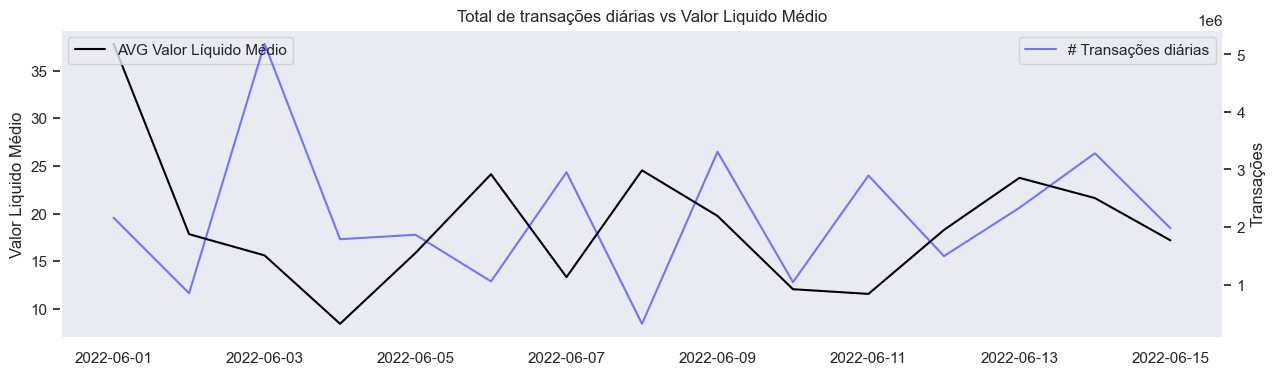

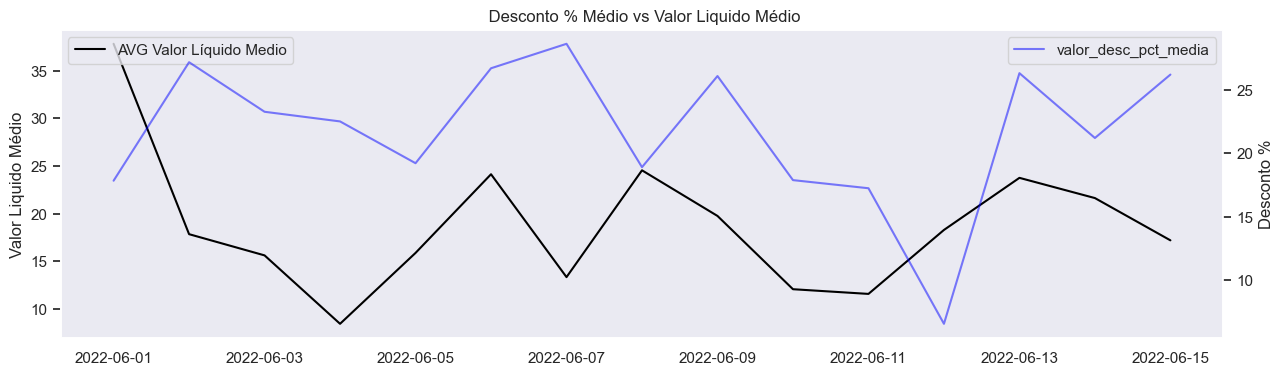

In [126]:
# New plot: 2-y axis
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

plt.title("Total de transações diárias vs Valor Liquido Médio")
ax1.grid(False)
ax2.grid(False)

ax1.plot(
    stats_vendas.loc[stats_vendas.index[0] :].index,
    stats_vendas.loc[stats_vendas.index[0] :].valor_liquido_total_media,
    color="black",
    label="AVG Valor Líquido Médio",
)
ax2.plot(
    stats_vendas["#_transacoes"].index,
    stats_vendas["#_transacoes"],
    color="blue",
    label="# Transações diárias",
    alpha=0.5,
)


# ax1.set_xlabel('Date')
ax1.set_ylabel("Valor Liquido Médio")
ax2.set_ylabel("Transações")

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()


###############################################################

# New plot: 2-y axis
fig, ax1 = plt.subplots(figsize=(15, 4))
ax2 = ax1.twinx()

plt.title(" Desconto % Médio vs Valor Liquido Médio")
ax1.grid(False)
ax2.grid(False)

ax1.plot(
    stats_vendas.loc[stats_vendas.index[0] :].index,
    stats_vendas.loc[stats_vendas.index[0] :].valor_liquido_total_media,
    color="black",
    label="AVG Valor Líquido Medio",
)
ax2.plot(
    stats_vendas["valor_desc_pct_media"].index,
    stats_vendas["valor_desc_pct_media"],
    color="blue",
    label="valor_desc_pct_media",
    alpha=0.5,
)


# ax1.set_xlabel('Date')
ax1.set_ylabel("Valor Liquido Médio")
ax2.set_ylabel("Desconto %")

ax1.legend(loc=2)
ax2.legend(loc=1)

plt.show()

#### Comportamento de variaveis por dia da semana

In [110]:
df2

,cod_cliente,data_emissao,cod_item,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_desconto_pct,valor_liquido_total,valor_liquido_unitario,valor_liquido_unitario_DEBUG,Equal
0,2211,2022-06-01,357537,1,83.06,11.63,14.00,71.43,71.43,71.43,1
1,2211,2022-06-01,647860,1,149.49,0.00,0.00,149.49,149.49,149.49,1
2,4553,2022-06-01,116065,1,94.90,0.00,0.00,94.90,94.90,94.90,1
3,4553,2022-06-01,853800,2,24.99,15.00,60.02,19.98,9.99,9.99,1
4,4553,2022-06-01,880550,1,71.99,0.00,0.00,71.99,71.99,71.99,1
...,...,...,...,...,...,...,...,...,...,...,...
2036851,142582667,2022-06-15,304940,1,10.49,2.10,20.02,8.39,8.39,8.39,1
2036852,142582667,2022-06-15,379701,1,34.26,18.87,55.08,15.39,15.39,15.39,1
2036853,142582667,2022-06-15,431370,1,26.14,6.54,25.02,19.60,19.60,19.60,1
2036854,142582667,2022-06-15,826940,1,15.00,4.50,30.00,10.50,10.50,10.50,1


[Text(0.5, 0, '')]

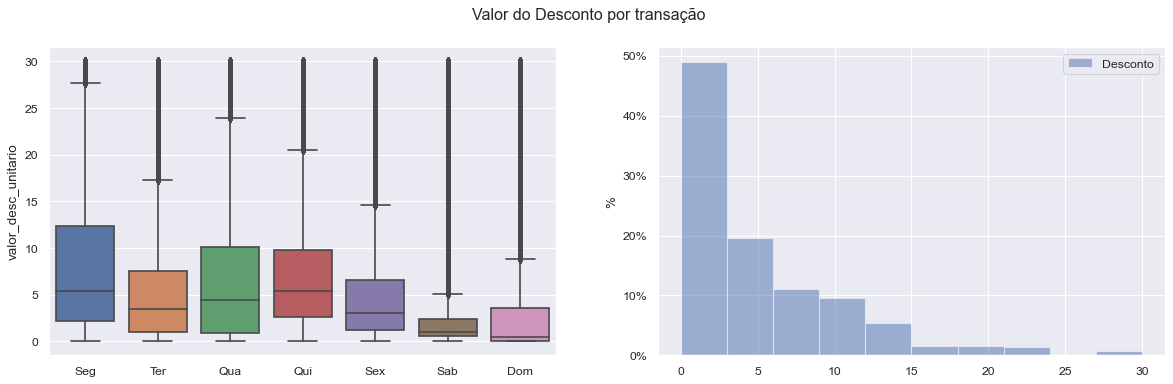

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=80)

fig.suptitle("Valor do Desconto por transação")

ax = plt.hist(
    df2["valor_desc_unitario"],
    bins=10,
    alpha=0.5,
    label="Desconto",
    weights=np.ones(len(df2)) / len(df2),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("")

ax = sns.boxplot(
    x="dia_da_semana",
    y="valor_desc_unitario",
    data=df2,
    orient="v",
    order=["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"],
    ax=axes[0],
)
ax.set(xlabel=None)

[Text(0.5, 0, '')]

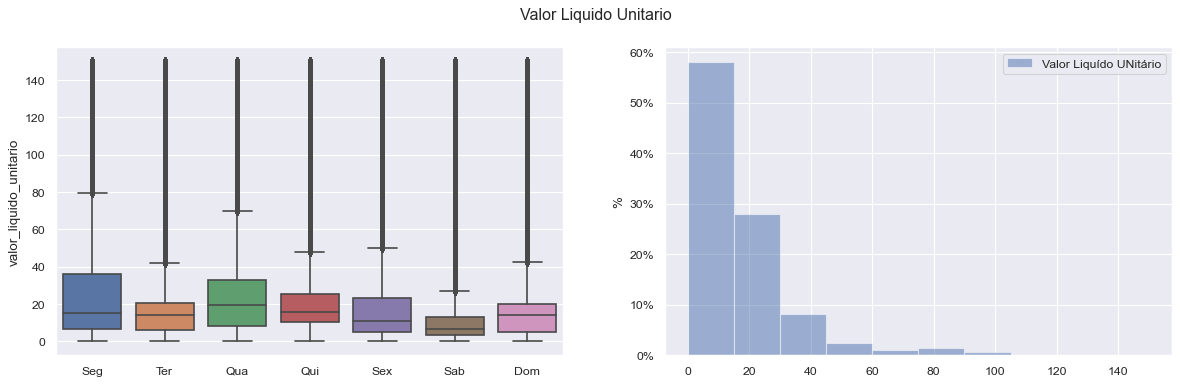

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=80)

fig.suptitle("Valor Liquido Unitario")

ax = plt.hist(
    df2["valor_liquido_unitario"],
    bins=10,
    alpha=0.5,
    label="Valor Liquído UNitário",
    weights=np.ones(len(df2)) / len(df2),
)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc="upper right")
plt.ylabel("%")
plt.title("")

ax = sns.boxplot(
    x="dia_da_semana",
    y="valor_liquido_unitario",
    data=df2,
    orient="v",
    order=["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"],
    ax=axes[0],
)
ax.set(xlabel=None)

## Parte B. Clusterização

### Passo 1. Como o exercício trata de uma clusterização a nível de clientes, devo agrupar a tabela de vendas para clientes

Ao invés de utilizar diversas variáveis para fazer a clusterização (testei com várias váriaveis - fiz a normalização), optei por construir um índice de releväncia por cliente que considera frequência de compra, quantidade e valor.

In [142]:
### Agruoar dados e construir indice de relevancia por cliente

df2_stats = df2.groupby(["cod_cliente"], dropna=False, as_index=True, sort=True).agg(
    {
        "data_emissao": ["nunique"],
        "quantidade": ["sum"],
        "valor_bruto_unitario": ["sum"],
        "valor_desc_unitario": ["sum"],
        "valor_liquido_total": ["sum"],
    }
)


df2_stats.columns = df2_stats.columns.droplevel(1)

df2_stats.rename(columns={"data_emissao": "dias_compra"}, inplace=True)

### Passo 2: Construir indicador de frequência

In [143]:
## Criar range da data para calcular frequencia de compra
range_analise = (
    df2["data_emissao"].max() - df2["data_emissao"].min()
) / np.timedelta64(1, "D")
range_analise


df2_stats["frequencia"] = df2_stats["dias_compra"] / range_analise

### Passo 3: Construir índice de relevância

In [144]:
### Criar indice que pondere frequencia, quantidade e valor gasto em compras
df2_stats["indice_relevancia"] = (
    df2_stats["frequencia"] * 0.6
    + df2_stats["valor_liquido_total"] * 0.3
    + df2_stats["quantidade"] * 0.1
)

df2_stats.reset_index(inplace=True)
# stats_sexo.set_index("sexo", inplace=True)

df2_stats

,cod_cliente,dias_compra,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_liquido_total,frequencia,indice_relevancia
0,2138,1,3,55.25,6.75,77.81,0.07,23.69
1,2145,1,1,5.99,0.00,5.99,0.07,1.94
2,2211,1,2,232.55,11.63,220.92,0.07,66.52
3,2271,1,2,38.98,0.00,38.98,0.07,11.94
4,2392,1,5,107.78,2.00,105.78,0.07,32.28
...,...,...,...,...,...,...,...,...
1345443,142582663,14,159,3266.21,746.96,2625.38,1.00,804.11
1345444,142582664,14,159,3266.21,746.96,2625.38,1.00,804.11
1345445,142582665,14,159,3266.21,746.96,2625.38,1.00,804.11
1345446,142582666,14,159,3266.21,746.96,2625.38,1.00,804.11


### Passo 4: Filtrar para clientes cadastrados (df_clientes)

In [138]:
df_clientes.rename(columns={"codigo_cliente": "cod_cliente"}, inplace=True)
df_clientes["cadastro"] = 1

In [145]:
df_clientes.rename(columns={"codigo_cliente": "cod_cliente"}, inplace=True)

df_all = df2_stats.merge(df_clientes, on="cod_cliente", how="left")

df_cluster = df_all[df_all["cadastro"] == 1]
df_cluster

,cod_cliente,dias_compra,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_liquido_total,frequencia,indice_relevancia,data_nascimento,idade,...,flag_optin_celular,flag_optin_fixo,flag_optin_email,uf,cidade,bairro,status,faixa_etaria,sul,cadastro
1,2145,1,1,5.99,0.00,5.99,0.07,1.94,1948-05-08,74.00,...,S,N,N,SC,FLORIANOPOLIS,SANTO ANTONIO DE LISBOA,ATIVO,"(70.0, 80.0]",1.00,1.00
4,2392,1,5,107.78,2.00,105.78,0.07,32.28,1979-02-20,43.00,...,S,N,N,RS,NOVO HAMBURGO,JARDIM MAUA,ATIVO,"(40.0, 50.0]",1.00,1.00
5,2399,1,2,21.19,1.48,19.71,0.07,6.16,1993-10-28,28.00,...,S,N,N,SC,FLORIANOPOLIS,PANTANAL,ATIVO,"(20.0, 30.0]",1.00,1.00
6,2877,1,2,84.22,9.73,74.49,0.07,22.59,1957-05-10,65.00,...,S,N,N,PR,CURITIBA,JARDIM DAS AMERICAS,ATIVO,"(60.0, 70.0]",1.00,1.00
7,3195,1,3,76.57,0.00,76.57,0.07,23.31,1998-07-17,24.00,...,S,N,S,RS,CAXIAS DO SUL,MEDIANEIRA,ATIVO,"(20.0, 30.0]",1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344920,142447337,1,3,47.56,13.59,33.97,0.07,10.53,1986-03-18,36.00,...,S,N,N,SC,FLORIANOPOLIS,CANASVIEIRAS,ATIVO,"(30.0, 40.0]",1.00,1.00
1344924,142457967,1,2,62.99,18.00,44.99,0.07,13.74,1980-02-15,42.00,...,S,S,N,RS,PORTO ALEGRE,PRAIA DE BELAS,ATIVO,"(40.0, 50.0]",1.00,1.00
1344957,142532747,1,5,118.47,33.68,154.59,0.07,46.92,1964-09-28,57.00,...,N,N,N,RS,PORTO ALEGRE,JARDIM CARVALHO,ATIVO,"(50.0, 60.0]",1.00,1.00
1344962,142550669,1,13,212.75,34.29,193.76,0.07,59.47,1953-07-15,69.00,...,S,S,N,RS,GRAVATAI,NEOPOLIS,ATIVO,"(60.0, 70.0]",1.00,1.00


Agorta tenho as informações de vendas a nível de clientes cadastrados na base disponibilizada. 

### Passo 5: Diferenciar por genêro

Sabe-se que Homens e mulheres tem conjunto de preferências distintos. Avaliar se esses grupos na amostra são estatisticamente distintos

In [146]:
### Identificaer cliegtne mediano por sexo

df1_stats_mediano = df_cluster.groupby(
    ["sexo"], dropna=False, as_index=True, sort=True
).agg(
    {
        "cod_cliente": ["nunique"],
        "quantidade": ["mean"],
        "valor_bruto_unitario": ["mean"],
        "valor_desc_unitario": ["mean"],
        "valor_liquido_total": ["mean"],
        "indice_relevancia": ["mean"],
    }
)


df1_stats_mediano.columns = df1_stats_mediano.columns.droplevel(1)

df1_stats_mediano.rename(
    columns={"cod_cliente": "#_clientes", "data_emissao": "dias_compra"}, inplace=True
)

df1_stats_mediano["share_sexo"] = (
    df1_stats_mediano["#_clientes"] / len(df_cluster) * 100
)

df1_stats_mediano.reset_index(inplace=True)
# stats_mediano_sexo.set_index("sexo", inplace=True)

df1_stats_mediano

,sexo,#_clientes,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_liquido_total,indice_relevancia,share_sexo
0,F,558866,4.60,117.71,20.69,102.93,31.40,69.02
1,M,250813,3.85,100.43,19.08,87.71,26.76,30.98


#### t-test para diferença de médias

In [148]:
df_cluster_M = df_cluster[df_cluster["sexo"] == "M"]
df_cluster_F = df_cluster[df_cluster["sexo"] == "F"]

In [149]:
# perform independent two sample t-test

from scipy.stats import ttest_ind

## T-test para quantidade

t_stat, p_value = ttest_ind(df_cluster_M["quantidade"], df_cluster_F["quantidade"])

alpha = 0.05

# Resuyltados
if p_value < alpha:
    print("QUANTIDADE -> Rejeita-se H0 -> existe diferença estatística entre grupos.")
else:
    print("QUANTIDADE -> não se rejeito HO -> grupos são homogêneos")

## T-test para quantidade
t_stat, p_value = ttest_ind(
    df_cluster_M["valor_liquido_total"], df_cluster_F["valor_liquido_total"]
)

# Resuyltados
if p_value < alpha:
    print(
        "VALOR LIQUIDO TOTAL-> Rejeita-se H0 -> existe diferença estatística entre grupos."
    )
else:
    print("VALOR LIQUIDO TOTAL -> não se rejeito HO -> grupos são homogêneos")

QUANTIDADE -> Rejeita-se H0 -> existe diferença estatística entre grupos.
VALOR LIQUIDO TOTAL-> Rejeita-se H0 -> existe diferença estatística entre grupos.


### Passo 6: Avaliar outliers no índice de relevância por genêro

In [159]:
df_cluster.indice_relevancia.describe()

count   809679.00
mean        29.96
std         33.83
min          0.15
25%          9.48
50%         19.85
75%         38.38
max       2434.78
Name: indice_relevancia, dtype: float64

Text(0.5, 1.0, 'TIndice de relevância por idade')

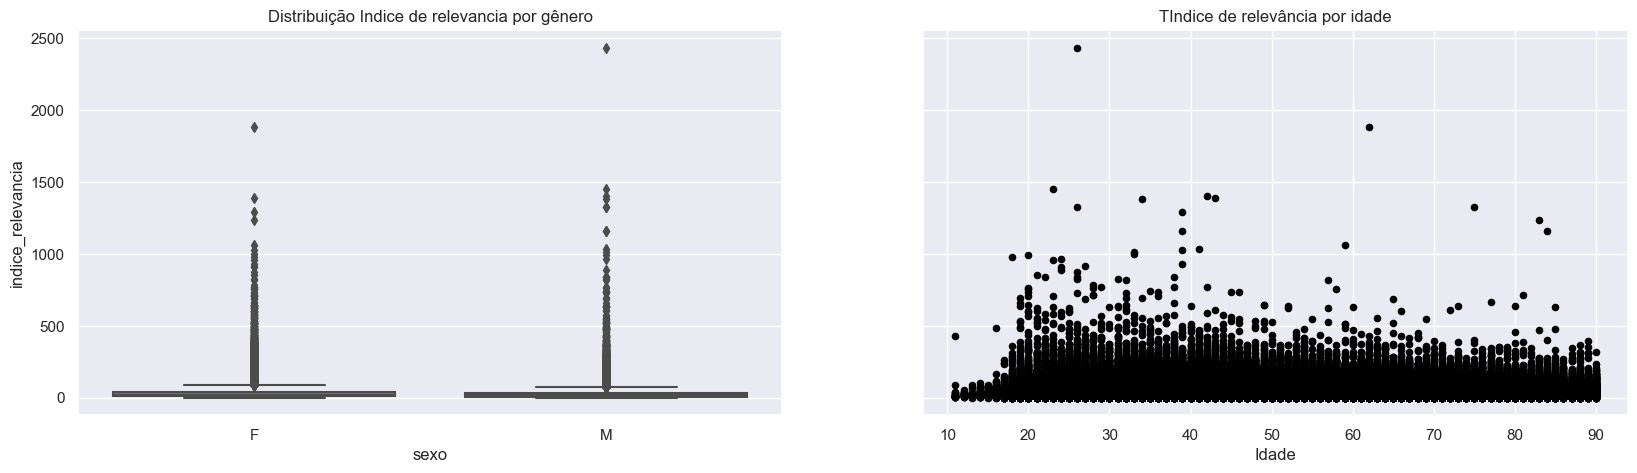

In [150]:
## Scatter plotting for flat_rate and GrLivArea.
fig, (ax1, ax2) = plt.subplots(figsize=(20, 5), ncols=2, sharey=True)

ax = sns.boxplot(data=df_cluster, x="sexo", y="indice_relevancia", ax=ax1)
ax.set_title("Distribuição Indice de relevancia por gênero")

df_cluster.plot.scatter(x="idade", y="indice_relevancia", c="black", ax=ax2)
plt.xlabel("Idade")
plt.title("TIndice de relevância por idade")

#### Filtrar os dados

In [160]:
df_cluster_M_limite = df_cluster[
    (df_cluster["sexo"] == "M") & (df_cluster["indice_relevancia"] <= 200)
]
df_cluster_F_limite = df_cluster[
    (df_cluster["sexo"] == "F") & (df_cluster["indice_relevancia"] <= 200)
]

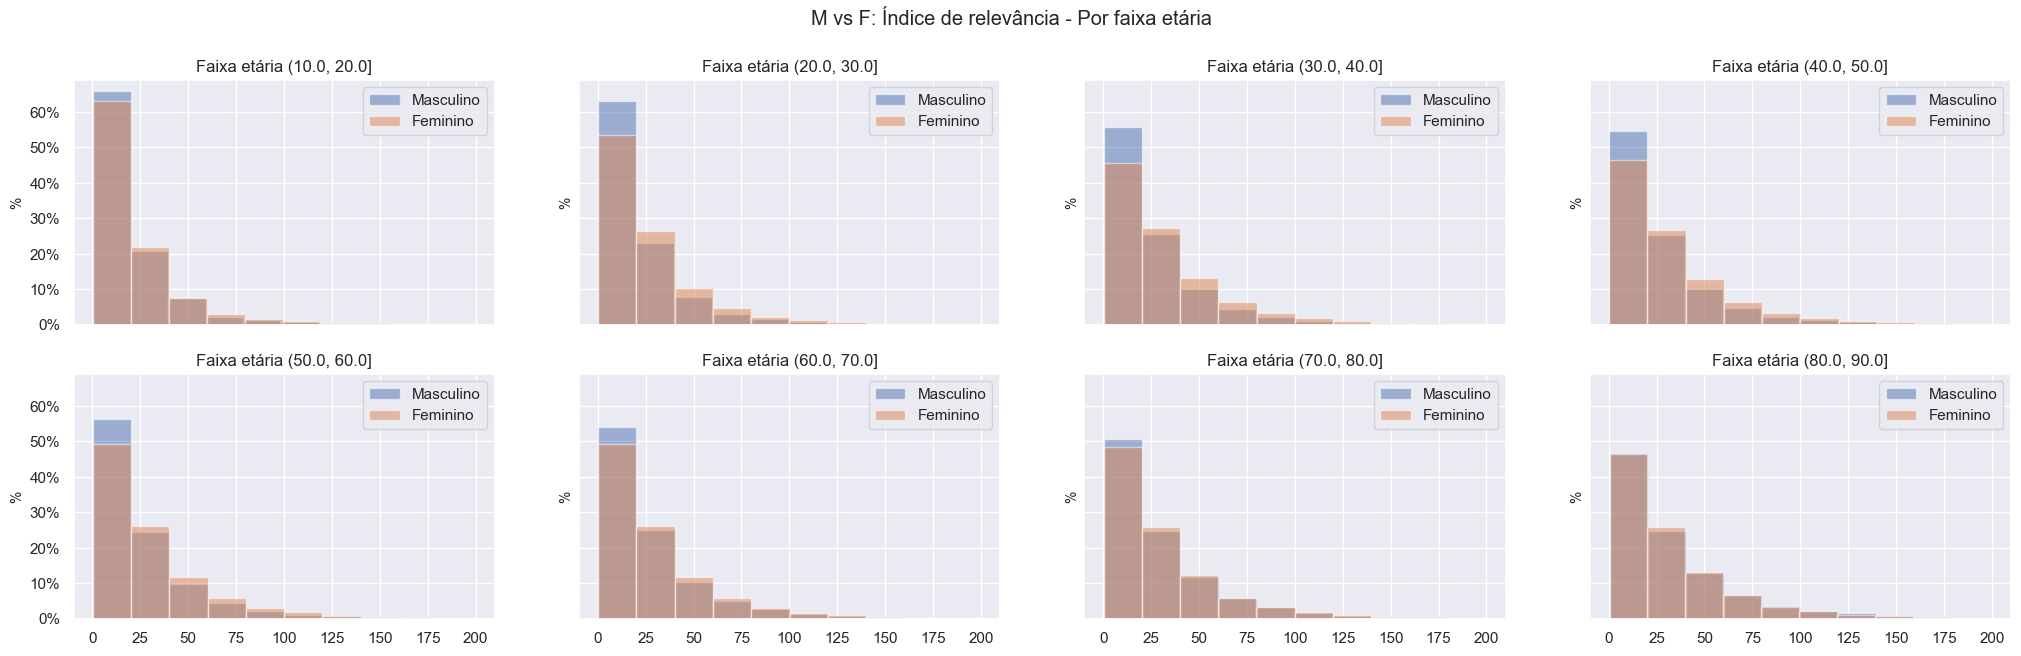

In [161]:
fig, axs = plt.subplots(2, 4, figsize=(25, 7), sharex=True, sharey=True)
fig.suptitle("M vs F: Índice de relevância - Por faixa etária")
axs = axs.flatten()
bands = df_cluster_M_limite.faixa_etaria.unique().sort_values()

for band, ax in zip(bands, axs):
    age_band = df_cluster_M_limite[df_cluster_M_limite["faixa_etaria"] == band]
    ax.hist(
        age_band.indice_relevancia,
        alpha=0.5,
        bins=10,
        label="Masculino",
        weights=np.ones(len(age_band)) / len(age_band),
    )
    age_band_2 = df_cluster_F_limite[df_cluster_F_limite["faixa_etaria"] == band]
    ax.hist(
        age_band_2.indice_relevancia,
        alpha=0.5,
        bins=10,
        label="Feminino",
        weights=np.ones(len(age_band_2)) / len(age_band_2),
    )
    ax.set_title(f"Faixa etária {band}")
    ax.legend()
    ax.set_ylabel("%", fontsize=10)
    ax.yaxis.set_major_formatter(PercentFormatter(1))

### Passo 7: Clusterizacao MASCULINO

In [ ]:
from pylab import plot, show
from numpy import vstack, array
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans

In [163]:
cluster_M = df_cluster_M_limite[["indice_relevancia"]]

Text(0.5, 1.0, 'Elbow curve')

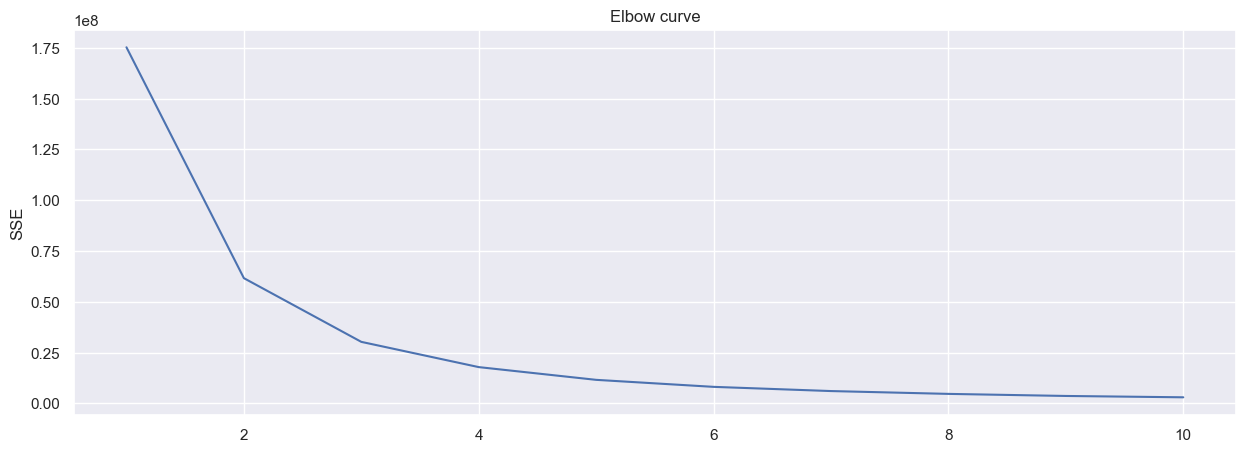

In [164]:
## Need to ranspose the matriz to get lanes in row indexes
sse = []

for k in range(1, 11):
    k_means = KMeans(n_clusters=k)
    k_means.fit(cluster_M)
    sse.append(k_means.inertia_)  # #SSE for each n_clusters


fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), sse)
plt.grid(True)
plt.ylabel("SSE")
plt.title("Elbow curve")

In [165]:
y_kmeans = KMeans(n_clusters=4).fit(cluster_M)
clusters = y_kmeans.labels_

pd.DataFrame({"Customers": df_cluster_M_limite.cod_cliente, "Clusters": clusters})
df_cluster_M_limite["cluster_no"] = clusters
df_cluster_M_limite["cluster_no"] = df_cluster_M_limite["cluster_no"] + 1

df_cluster_M_limite

,cod_cliente,dias_compra,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_liquido_total,frequencia,indice_relevancia,data_nascimento,idade,...,flag_optin_fixo,flag_optin_email,uf,cidade,bairro,status,faixa_etaria,sul,cadastro,cluster_no
4,2392,1,5,107.78,2.00,105.78,0.07,32.28,1979-02-20,43.00,...,N,N,RS,NOVO HAMBURGO,JARDIM MAUA,ATIVO,"(40.0, 50.0]",1.00,1.00,3
5,2399,1,2,21.19,1.48,19.71,0.07,6.16,1993-10-28,28.00,...,N,N,SC,FLORIANOPOLIS,PANTANAL,ATIVO,"(20.0, 30.0]",1.00,1.00,2
6,2877,1,2,84.22,9.73,74.49,0.07,22.59,1957-05-10,65.00,...,N,N,PR,CURITIBA,JARDIM DAS AMERICAS,ATIVO,"(60.0, 70.0]",1.00,1.00,3
9,4225,1,7,145.87,38.57,114.15,0.07,34.99,1978-06-08,44.00,...,N,N,PR,CURITIBA,CAJURU,ATIVO,"(40.0, 50.0]",1.00,1.00,3
16,4516,1,2,80.98,20.49,60.49,0.07,18.39,1995-11-17,26.00,...,N,N,RS,PORTO ALEGRE,SARANDI,ATIVO,"(20.0, 30.0]",1.00,1.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344834,142091425,1,3,128.39,5.51,122.88,0.07,37.21,1965-05-05,57.00,...,S,N,RS,CANOAS,OLARIA,ATIVO,"(50.0, 60.0]",1.00,1.00,3
1344839,142112033,1,2,25.85,0.00,25.85,0.07,8.00,1993-08-27,29.00,...,N,N,PR,LONDRINA,SANTA ROSA,ATIVO,"(20.0, 30.0]",1.00,1.00,2
1344847,142140144,1,6,266.33,41.64,224.69,0.07,68.05,1971-11-01,50.00,...,S,S,RS,BENTO GONCALVES,CENTRO,ATIVO,"(40.0, 50.0]",1.00,1.00,1
1344870,142323793,9,32,852.01,234.58,617.43,0.64,188.81,1987-01-16,35.00,...,S,S,RS,CAPAO DA CANOA,GUARANI,ATIVO,"(30.0, 40.0]",1.00,1.00,4


In [166]:
### Identificar receita e quantidade diária

stats_cluster_M = df_cluster_M_limite.groupby(
    ["cluster_no"], dropna=False, as_index=True, sort=True
).agg(
    {
        "cluster_no": ["count"],
        "idade": ["mean"],
        "dias_compra": ["mean"],
        "quantidade": ["mean"],
        "frequencia": ["mean"],
        "valor_liquido_total": ["mean"],
        "indice_relevancia": ["mean"],
    }
)

stats_cluster_M.columns = stats_cluster_M.columns.droplevel(1)
stats_cluster_M.rename(
    columns={
        "cluster_no": "#_clientes",
    },
    inplace=True,
)

stats_cluster_M["share_clientes"] = (
    stats_cluster_M["#_clientes"] / len(df_cluster_M_limite)
) * 100

stats_cluster_M = stats_cluster_M[
    [
        "#_clientes",
        "share_clientes",
        "idade",
        "dias_compra",
        "quantidade",
        "frequencia",
        "valor_liquido_total",
        "indice_relevancia",
    ]
]


stats_cluster_M

,#_clientes,share_clientes,idade,dias_compra,quantidade,frequencia,valor_liquido_total,indice_relevancia
cluster_no,,,,,,,,
1,26458,10.58,50.81,2.26,7.82,0.16,221.13,67.22
2,145080,58.03,47.45,1.14,2.16,0.08,32.87,10.12
3,71348,28.54,48.71,1.57,4.35,0.11,106.81,32.54
4,7138,2.85,51.85,3.37,14.17,0.24,418.15,127.00


Text(0.5, 1.0, 'MASCULINO: Clusterizaçao de clientes')

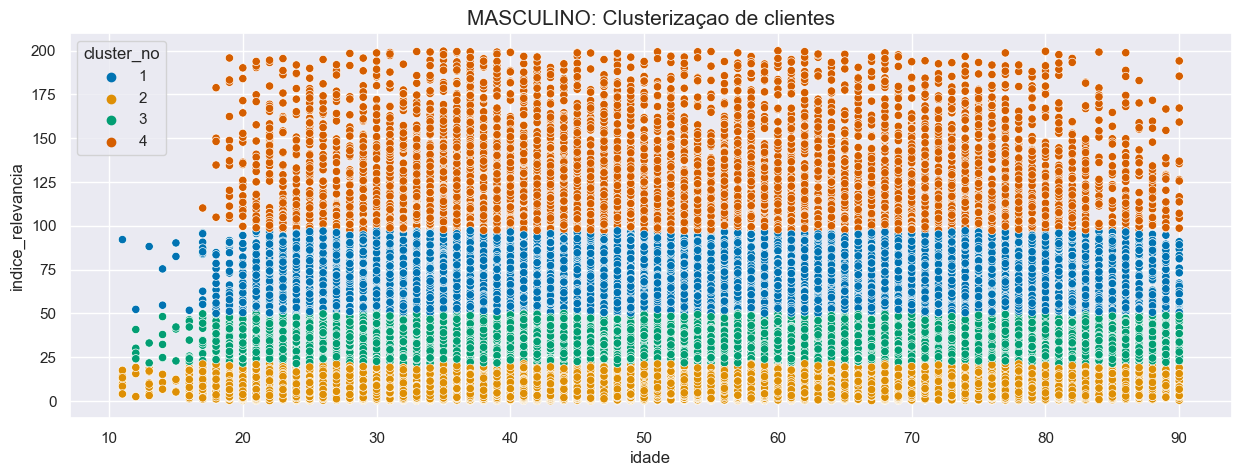

In [167]:
plt.figure(figsize=(15, 5))

sns.scatterplot(
    data=df_cluster_M_limite,
    x="idade",
    y="indice_relevancia",
    hue="cluster_no",
    palette="colorblind",
)

plt.title("MASCULINO: Clusterizaçao de clientes", size=15)

### Passo 8. Clusterizacao FEMININO

In [168]:
cluster_F = df_cluster_F_limite[["indice_relevancia"]]
len(cluster_F)

556191

Text(0.5, 1.0, 'Elbow curve')

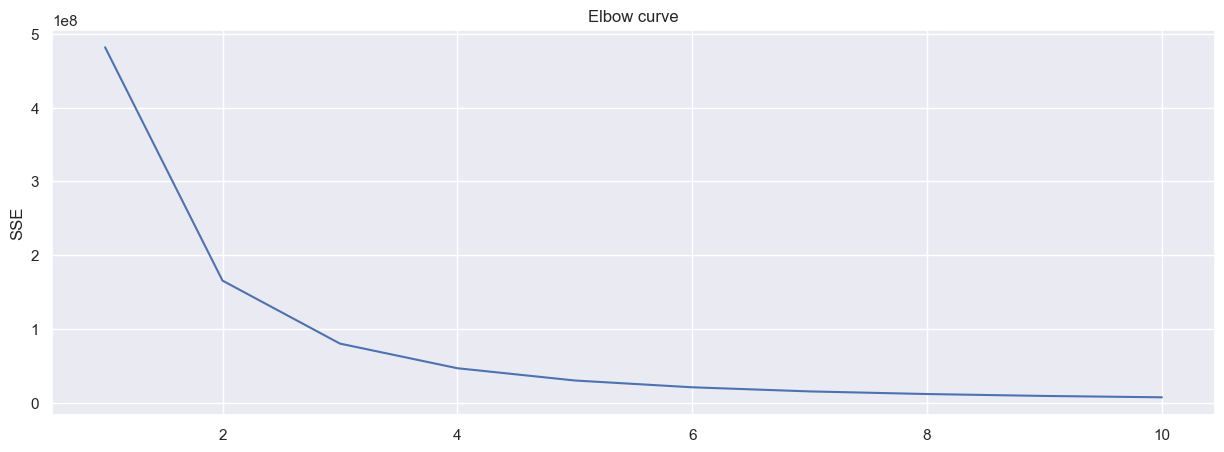

In [169]:
## Need to ranspose the matriz to get lanes in row indexes
sse = []

for k in range(1, 11):
    k_means = KMeans(n_clusters=k)
    k_means.fit(cluster_F)
    sse.append(k_means.inertia_)  # #SSE for each n_clusters


fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), sse)
plt.grid(True)
plt.ylabel("SSE")
plt.title("Elbow curve")

In [170]:
y_kmeans = KMeans(n_clusters=4).fit(cluster_F)
clusters = y_kmeans.labels_

pd.DataFrame({"Customers": df_cluster_F_limite.cod_cliente, "Clusters": clusters})
df_cluster_F_limite["cluster_no"] = clusters + 1
df_cluster_F_limite

,cod_cliente,dias_compra,quantidade,valor_bruto_unitario,valor_desc_unitario,valor_liquido_total,frequencia,indice_relevancia,data_nascimento,idade,...,flag_optin_fixo,flag_optin_email,uf,cidade,bairro,status,faixa_etaria,sul,cadastro,cluster_no
1,2145,1,1,5.99,0.00,5.99,0.07,1.94,1948-05-08,74.00,...,N,N,SC,FLORIANOPOLIS,SANTO ANTONIO DE LISBOA,ATIVO,"(70.0, 80.0]",1.00,1.00,2
7,3195,1,3,76.57,0.00,76.57,0.07,23.31,1998-07-17,24.00,...,N,S,RS,CAXIAS DO SUL,MEDIANEIRA,ATIVO,"(20.0, 30.0]",1.00,1.00,4
10,4252,1,1,69.90,0.00,69.90,0.07,21.11,1998-07-23,24.00,...,N,N,RS,PORTO ALEGRE,CAMAQUA,ATIVO,"(20.0, 30.0]",1.00,1.00,2
12,4268,2,7,145.03,8.47,136.56,0.14,41.75,1993-12-20,28.00,...,N,S,RS,PORTO ALEGRE,CRISTAL,ATIVO,"(20.0, 30.0]",1.00,1.00,4
13,4301,1,2,14.18,3.94,10.24,0.07,3.31,1987-02-25,35.00,...,N,S,RS,ENTRE-IJUIS,CENTRO,ATIVO,"(30.0, 40.0]",1.00,1.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344884,142346142,1,2,93.88,0.00,93.88,0.07,28.41,2002-02-17,20.00,...,N,S,RS,PELOTAS,CENTRO,ATIVO,"(10.0, 20.0]",1.00,1.00,4
1344916,142432257,1,3,91.47,23.50,67.97,0.07,20.73,1999-02-03,23.00,...,N,N,RS,SANTA CRUZ DO SUL,RAUBER,ATIVO,"(20.0, 30.0]",1.00,1.00,2
1344920,142447337,1,3,47.56,13.59,33.97,0.07,10.53,1986-03-18,36.00,...,N,N,SC,FLORIANOPOLIS,CANASVIEIRAS,ATIVO,"(30.0, 40.0]",1.00,1.00,2
1344957,142532747,1,5,118.47,33.68,154.59,0.07,46.92,1964-09-28,57.00,...,N,N,RS,PORTO ALEGRE,JARDIM CARVALHO,ATIVO,"(50.0, 60.0]",1.00,1.00,4


In [171]:
### Identificar receita e quantidade diária

stats_cluster_F = df_cluster_F_limite.groupby(
    ["cluster_no"], dropna=False, as_index=True, sort=True
).agg(
    {
        "cluster_no": ["count"],
        "idade": ["mean"],
        "dias_compra": ["mean"],
        "quantidade": ["mean"],
        "frequencia": ["mean"],
        "valor_liquido_total": ["mean"],
        "indice_relevancia": ["mean"],
    }
)

stats_cluster_F.columns = stats_cluster_F.columns.droplevel(1)
stats_cluster_F.rename(
    columns={
        "cluster_no": "#_clientes",
    },
    inplace=True,
)

stats_cluster_F["share_clientes"] = (
    stats_cluster_F["#_clientes"] / len(df_cluster_F_limite)
) * 100


stats_cluster_F

,#_clientes,idade,dias_compra,quantidade,frequencia,valor_liquido_total,indice_relevancia,share_clientes
cluster_no,,,,,,,,
1,70637,45.94,2.14,8.66,0.15,229.96,69.95,12.70
2,297731,44.87,1.14,2.41,0.08,36.45,11.23,53.53
3,21052,46.10,3.21,15.32,0.23,429.61,130.55,3.79
4,166771,45.17,1.53,4.95,0.11,113.90,34.73,29.98


Text(0.5, 1.0, 'FEMININO: Clusterizaçao de clientes')

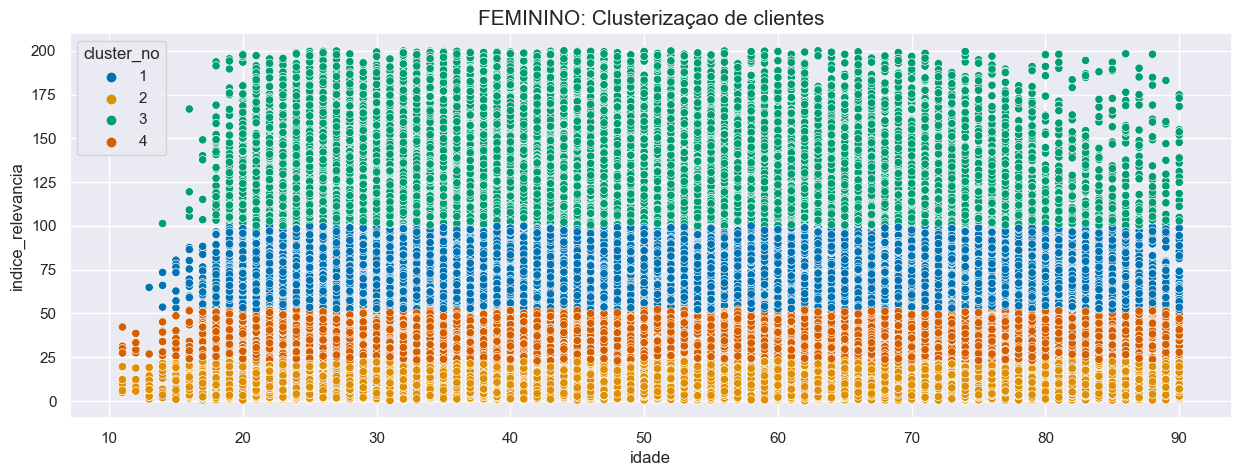

In [172]:
plt.figure(figsize=(15, 5))

sns.scatterplot(
    data=df_cluster_F_limite,
    x="idade",
    y="indice_relevancia",
    hue="cluster_no",
    palette="colorblind",
)

plt.title("FEMININO: Clusterizaçao de clientes", size=15)

### Conclusão:

Após a eliminação de outliers, com base na variável índice de referência o processo de clusterização foi capaz de separar os clientes da Panvel. 